In [1]:
!pip install torchtext==0.6.0

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchtext.datasets import text_classification
from torch.utils.data.dataset import random_split
from torchtext.data.utils import ngrams_iterator
from torchtext.data.utils import get_tokenizer

In [3]:
NGRAMS=2
if not os.path.isdir('./__data__'):
    os.mkdir('./__data__')

train_dataset, test_dataset = text_classification.DATASETS['AG_NEWS'](root='./__data__', ngrams=NGRAMS, vocab=None)

120000lines [00:07, 16657.87lines/s]
120000lines [00:16, 7203.23lines/s]
7600lines [00:01, 7443.76lines/s]


In [4]:
class TextSentiment(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super(TextSentiment, self).__init__()
        
        # self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_classes)
        self.init_weights()
        
    def init_weights(self):
        init_range = 0.5
        
        self.embedding.weight.data.uniform_(-init_range, init_range)
        self.fc.weight.data.uniform_(-init_range, init_range)
        self.fc.bias.data.zero_()
        
    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)

        return self.fc(embedded)

In [5]:
# hyperparameters
vocab_size = len(train_dataset.get_vocab())
embed_dim = 128
batch_size = 64
epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(train_dataset.get_labels())

print(f'processing on {device}')

processing on cuda


In [6]:
# initialize model
model = TextSentiment(vocab_size, embed_dim, num_classes).to(device)

In [7]:
# generate the batch
def generate_batch(batch):
    label = torch.tensor([entry[0] for entry in batch])
    text = [entry[1] for entry in batch]
    offsets = [0] + [len(entry) for entry in text]
    
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text = torch.cat(text)
    return text, offsets, label

In [8]:
def train(train_data):
    t_loss, t_acc = 0, 0
    
    # get data
    data = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)
    
    for i, (text, offsets, cls) in enumerate(data):
        optimizer.zero_grad()

        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)

        # get output from models
        output = model(text, offsets)

        loss = criterion(output, cls)
        t_loss += loss.item()
        loss.backward()

        optimizer.step()

        acc = (output.argmax(1) == cls).sum().item()
        t_acc += acc

    scheduler.step()

    return t_loss / len(train_data), t_acc / len(train_data)

def test(test_data):
    t_loss, t_acc = 0, 0

    data = DataLoader(test_data, batch_size=batch_size, collate_fn=generate_batch)

    for text, offsets, cls in data:

        text, offsets, cls = text.to(device), offsets.to(device), cls.to(device)

        with torch.no_grad():
            output = model(text, offsets)

            loss = criterion(output, cls)
            t_loss += loss.item()

            t_acc += (output.argmax(1) == cls).sum().item()

    return t_loss / len(test_data), t_acc / len(test_data)

In [9]:
# train the model
history = {'epochs': range(epochs), 'loss': [], 'acc': [], 'val_loss': [], 'val_acc': []}

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=2.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

train_len = int(len(train_dataset) * 0.95)

train_data, valid_data = random_split(train_dataset, [train_len, len(train_dataset) - train_len])

for epoch in range(epochs):
    # start time for each epaoch
    start = time.time()
    
    train_loss, train_acc = train(train_data)
    val_loss, val_acc = test(valid_data)

    history['loss'].append(train_loss)
    history['acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f'Epoch {epoch+1}/{epochs}')
    print(f'{round(time.time() - start)}s - loss: {train_loss:.6f} - accuracy: {train_acc*100:.2f}% - '+\
          f'val_loss: {val_loss:.6f} - val_accuracy: {val_acc*100:.2f}%')

Epoch 1/20
3s - loss: 0.011309 - accuracy: 73.10% - val_loss: 0.006362 - val_accuracy: 86.42%
Epoch 2/20
3s - loss: 0.005625 - accuracy: 88.05% - val_loss: 0.005169 - val_accuracy: 89.53%
Epoch 3/20
3s - loss: 0.004541 - accuracy: 90.49% - val_loss: 0.004889 - val_accuracy: 89.82%
Epoch 4/20
3s - loss: 0.003913 - accuracy: 91.89% - val_loss: 0.004704 - val_accuracy: 90.13%
Epoch 5/20
3s - loss: 0.003465 - accuracy: 92.88% - val_loss: 0.004591 - val_accuracy: 90.33%
Epoch 6/20
3s - loss: 0.003113 - accuracy: 93.70% - val_loss: 0.004398 - val_accuracy: 91.02%
Epoch 7/20
3s - loss: 0.002825 - accuracy: 94.33% - val_loss: 0.004370 - val_accuracy: 90.77%
Epoch 8/20
3s - loss: 0.002589 - accuracy: 94.88% - val_loss: 0.004468 - val_accuracy: 90.20%
Epoch 9/20
3s - loss: 0.002386 - accuracy: 95.38% - val_loss: 0.004296 - val_accuracy: 91.05%
Epoch 10/20
3s - loss: 0.002218 - accuracy: 95.81% - val_loss: 0.004290 - val_accuracy: 91.05%
Epoch 11/20
3s - loss: 0.002073 - accuracy: 96.13% - val_lo

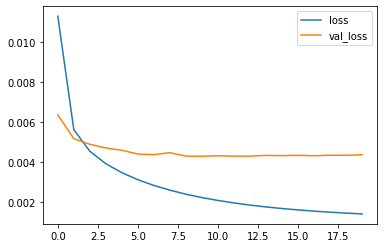

In [10]:
plt.plot(history['epochs'], history['loss'], label='loss')
plt.plot(history['epochs'], history['val_loss'], label='val_loss')
plt.legend()
plt.show()

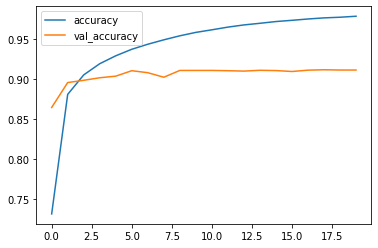

In [11]:
plt.plot(history['epochs'], history['acc'], label='accuracy')
plt.plot(history['epochs'], history['val_acc'], label='val_accuracy')
plt.legend()
plt.show()

In [12]:
test_loss, test_acc = test(test_dataset)
print(f'loss: {test_loss:.5} - accuracy: {test_acc*100:.2f}%')

loss: 0.0059589 - accuracy: 87.41%


In [13]:
# save the model
# torch.save(model, 'model.pth')

In [14]:
# test the model with one news
labels = {1 : "World", 2 : "Sports", 3 : "Business", 4 : "Sci/Tec"}

def evaluate(text, model, vocab, ngrams):
    tokenizer = get_tokenizer('basic_english')

    with torch.no_grad():
        text = torch.tensor([vocab[token] for token in ngrams_iterator(tokenizer(text), ngrams)]).to(device)
        output = model(text, torch.tensor([0]).to(device))
        return output.argmax(1).item() + 1

ex_text_str = "MEMPHIS, Tenn. – Four days ago, Jon Rahm was \
    enduring the season’s worst weather conditions on Sunday at The \
    Open on his way to a closing 75 at Royal Portrush, which \
    considering the wind and the rain was a respectable showing. \
    Thursday’s first round at the WGC-FedEx St. Jude Invitational \
    was another story. With temperatures in the mid-80s and hardly any \
    wind, the Spaniard was 13 strokes better in a flawless round. \
    Thanks to his best putting performance on the PGA Tour, Rahm \
    finished with an 8-under 62 for a three-stroke lead, which \
    was even more impressive considering he’d never played the \
    front nine at TPC Southwind."

ex_text_busn = "Some investors viewed the recent spike in coronavirus infections and deaths, along with a grim November\
    employment report, as an impetus for a quick deal on a COVID-19 stimulus bill, with economically sensitive sectors such\
    as consumer discretionary, materials leading gains."

vocab = train_dataset.get_vocab()

label = evaluate(ex_text_str, model, vocab, 2)
print(labels[label])

label2 = evaluate(ex_text_busn, model, vocab, 2)
print(labels[label2])

Sports
Business
